In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
import pandas as pd
from tqdm import tqdm_notebook
import io
from PIL import Image
from glob import glob
from collections import defaultdict
import os
import pickle
from io import BytesIO
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder

from kaggle_camera_model_id_lib.utils import PechkaBot, ImageList, NpzFolder, NCrops, TifFolderExFiles
from kaggle_camera_model_id_lib.utils import NpzFolderExFiles
from kaggle_camera_model_id_lib.models import VggHead, StyleVggHead, IEEEfcn, ResNetFC
from kaggle_camera_model_id_lib.utils import jpg_compress, equalize_v_hist, hsv_convert
from kaggle_camera_model_id_lib.utils import scale_crop_pad, gamma_correction

import imgaug as ia
from imgaug import augmenters as iaa

In [2]:
val_path = '/home/mephistopheies/storage2/data/camera-model-id/val/'
test_path = '/home/mephistopheies/storage2/data/camera-model-id/raw/test/'
model_path = '/home/mephistopheies/storage2/data/camera-model-id/models/resnet34fc/256_pretrained_random_aug_kaggle_10/best_model.tar'
out_dir = '/home/mephistopheies/storage2/data/camera-model-id/submit/'
model_type = 'resnet34fc_pretrained'
n_classes = 10
crop_size = 256
step = 128
num_workers = 1

do_random_aug_kaggle = False
p_random_aug_kaggle = 1.0
do_hard_aug = False
p_hard_aug = 0.5

to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

scale_05 = lambda img: scale_crop_pad(img, 0.5)
scale_08 = lambda img: scale_crop_pad(img, 0.8)
scale_15 = lambda img: scale_crop_pad(img, 1.5)
scale_20 = lambda img: scale_crop_pad(img, 2.0)
gamma_08 = lambda img: gamma_correction(img, 0.8)
gamma_12 = lambda img: gamma_correction(img, 1.2)
jpg_70 = lambda img: jpg_compress(img, (70, 71))
jpg_90 = lambda img: jpg_compress(img, (90, 91))
augs = [scale_05, scale_08, scale_15, scale_20, gamma_08, gamma_12, jpg_70, jpg_90]

blur = iaa.GaussianBlur(sigma=(0, 2))
sharpen = iaa.Sharpen(alpha=(0, 1), lightness=(0.5, 2))
emboss = iaa.Emboss(alpha=(0, 1), strength=(0, 2))
contrast_normalization = iaa.ContrastNormalization(alpha=(0.7, 1.3))
hard_aug = iaa.OneOf([blur, sharpen, emboss, contrast_normalization])
sometimes = iaa.Sometimes(p_hard_aug, hard_aug)


def random_aug_kaggle(img, p=0.5):
    if np.random.rand() < p:
        return random.choice(augs)(img)
    return img

def aug_train(img):
    if min(img.size) > crop_center_size:
        return random_flip(random_crop(center_crop(img)))
    return random_flip(random_crop(img))

def aug_optional(img):
    if do_hard_aug:
        img = Image.fromarray(sometimes.augment_image(np.array(img)))

    if do_random_aug_kaggle:
        img = random_aug_kaggle(img, p_random_aug_kaggle)
    return img

In [3]:
model_factory = {
    'Vgg19Head_E_2b_bn': lambda n_classes: VggHead(num_classes=n_classes, vgg_key='E_2b', load_vgg_bn=True, batch_norm=True),
    'Vgg19Head_E_3b_bn': lambda n_classes: VggHead(num_classes=n_classes, vgg_key='E_3b', load_vgg_bn=True, batch_norm=True),
    'Vgg19Head_E_bn': lambda n_classes: VggHead(num_classes=n_classes, load_vgg_bn=True, vgg_key='E', batch_norm=True),
    'Vgg11Head_A_bn': lambda n_classes: VggHead(num_classes=n_classes, load_vgg_bn=True, vgg_key='A', batch_norm=True),
    'Vgg11Head_A': lambda n_classes: VggHead(num_classes=n_classes, load_vgg_bn=True, vgg_key='A', batch_norm=False),
    'StyleVggHead_bn': lambda n_classes: StyleVggHead(num_classes=n_classes, load_vgg_bn=True),
    'IEEEfcn': lambda n_classes: IEEEfcn(n_classes),
    'resnet18fc_pretrained': lambda n_classes: ResNetFC(
        models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=n_classes, load_resnet='resnet18'),
    'resnet18fc': lambda n_classes: ResNetFC(
        models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=n_classes, load_resnet=None),
    'resnet18X_pretrained': lambda n_classes: ResNetX(
        models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=n_classes, load_resnet='resnet18'),
    'InceptionResNetV2fc_5_10_4': lambda n_classes: InceptionResNetV2fc(
        num_classes=n_classes, nun_block35=5, num_block17=10, num_block8=4),
    'InceptionResNetV2fcSmall_5_10': lambda n_classes: InceptionResNetV2fcSmall(
        num_classes=n_classes, nun_block35=5, num_block17=10),
    'resnet34fc_pretrained': lambda n_classes: ResNetFC(
        models.resnet.BasicBlock, [3, 4, 6, 3], num_classes=n_classes, load_resnet='resnet34'),
    'resnet50fc_pretrained': lambda n_classes: ResNetFC(
        models.resnet.Bottleneck, [3, 4, 6, 3], num_classes=n_classes, load_resnet='resnet50')
}

model = model_factory[model_type](n_classes)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model'])
loss_train = checkpoint['loss_train']
acc_train = checkpoint['acc_train']
loss_val = checkpoint['loss_val']
acc_val = checkpoint['acc_val']
class_to_idx = checkpoint['class_to_idx']
idx2class = dict([(v, k) for (k, v) in class_to_idx.items()])
print('Last state:\n  TLoss: %0.6f\n  TAcc:  %0.4f\n  VLoss: %0.6f\n  VAcc:  %0.4f' % 
    (loss_train[-1], acc_train[-1], loss_val[-1], acc_val[-1]))
del(checkpoint)
model = model.cuda()
model = model.eval()

Last state:
  TLoss: 0.014845
  TAcc:  0.9951
  VLoss: 0.100587
  VAcc:  0.9674


In [4]:
def loader(fname):
    with np.load(fname) as f:
        return f['data']

In [5]:
batch_size = 15

n = int((1 + (512 - 256)/128)**2)

ds_val = NpzFolderExFiles(
    val_path,
    transform=transforms.Compose([
        transforms.Lambda(lambda img: NCrops(img, crop_size=crop_size, step=step)),
        transforms.Lambda(lambda crops: torch.stack([normalize(to_tensor(aug_optional(Image.fromarray(crop)))) 
                                                     for crop in crops]))
    ]),
    target_transform=transforms.Compose([
            transforms.Lambda(lambda y: [y]*int(np.floor(1 + (512 - crop_size)/step))**2),
            transforms.Lambda(lambda ylist: torch.LongTensor(ylist))
    ]))
val_loader = torch.utils.data.DataLoader(    
    ds_val,
    batch_size=batch_size, 
    shuffle=False,
    num_workers=1, 
    pin_memory=True)


errors = defaultdict(list)
wins = defaultdict(list)
acc_val_batch = 0
for ix_batch, (X, Y, files) in tqdm_notebook(enumerate(val_loader), total=int(len(ds_val.imgs)/batch_size)):
    bs, ncrops, c, h, w = X.shape
    X = X.view(-1, c, h, w)
    Y = Y.view(ncrops*bs)

    X_var = Variable(X.cuda(), volatile=True)
    Y_var = Variable(Y.cuda(), volatile=True)

    log_p = model(X_var)

    acc_val_batch += ((log_p.max(1)[1] == Y_var).float().sum()/Y_var.shape[0]).data[0]
    
    ix_error = np.where(log_p.max(1)[1].cpu().data.numpy() != Y_var.cpu().data.numpy())[0]
    for ix in ix_error:
        img = X_var[int(ix), :, :, :].cpu().data.numpy()
        img = np.swapaxes(np.swapaxes(img, 0, 1), 1, 2)
        for i in range(3):
            img[:, :, i] = img[:, :, i]*normalize.std[i] + normalize.mean[i] 
        img[img > 1] = 1.0
        img[img < 0] = 0.0
        errors[files[int(ix/n)]].append(img.copy())
        
    ix_wins = np.where(log_p.max(1)[1].cpu().data.numpy() == Y_var.cpu().data.numpy())[0]
    for ix in ix_wins:
        img = X_var[int(ix), :, :, :].cpu().data.numpy()
        img = np.swapaxes(np.swapaxes(img, 0, 1), 1, 2)
        for i in range(3):
            img[:, :, i] = img[:, :, i]*normalize.std[i] + normalize.mean[i] 
        img[img > 1] = 1.0
        img[img < 0] = 0.0
        wins[files[int(ix/n)]].append(img.copy())
        

acc_val_batch /= ix_batch + 1
print(acc_val_batch)
print(len(errors))

Widget Javascript not detected.  It may not be installed or enabled properly.



0.9847407364845275
100


In [6]:
# mean_err = np.zeros((256, 256, 3))
# n = 0
# for fname, crops in tqdm_notebook(errors.items(), total=len(errors)):
#     for c in crops:
#         mean_err += c
#         n += 1
# mean_err /= n

# mean_win = np.zeros((256, 256, 3))
# n = 0
# for fname, crops in tqdm_notebook(wins.items(), total=len(wins)):
#     for c in crops:
#         mean_win += c
#         n += 1
# mean_win /= n


# std_err = np.zeros((256, 256, 3))
# n = 0
# for fname, crops in tqdm_notebook(errors.items(), total=len(errors)):
#     for c in crops:
#         std_err += (c - mean_err)**2
#         n += 1
# std_err /= n
# std_err = np.sqrt(std_err)

# std_win = np.zeros((256, 256, 3))
# n = 0
# for fname, crops in tqdm_notebook(wins.items(), total=len(wins)):
#     for c in crops:
#         std_win += (c - mean_win)**2
#         n += 1
# std_win /= n
# std_win = np.sqrt(std_win)

# print([mean_err[:, :, i].mean() for i in range(3)])
# print([std_err[:, :, i].mean() for i in range(3)])

# print([mean_win[:, :, i].mean() for i in range(3)])
# print([std_win[:, :, i].mean() for i in range(3)])

In [7]:
mean_err = []
for fname, crops in tqdm_notebook(errors.items(), total=len(errors)):
    for c in crops:
        mean_err.append(c.mean(axis=(0, 1)))
mean_err = np.array(mean_err)

mean_win = []
for fname, crops in tqdm_notebook(wins.items(), total=len(wins)):
    for c in crops:
        mean_win.append(c.mean(axis=(0, 1)))
mean_win = np.array(mean_win)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


In [8]:
mean_err.mean(axis=0)

array([ 0.45951024,  0.45129311,  0.4637458 ], dtype=float32)

In [9]:
mean_win.mean(axis=0)

array([ 0.426287  ,  0.41362131,  0.3791405 ], dtype=float32)

In [10]:
mean_err.std(axis=0)

array([ 0.2587913 ,  0.23552623,  0.25381884], dtype=float32)

In [11]:
mean_win.std(axis=0)

array([ 0.19237147,  0.18181637,  0.19050217], dtype=float32)

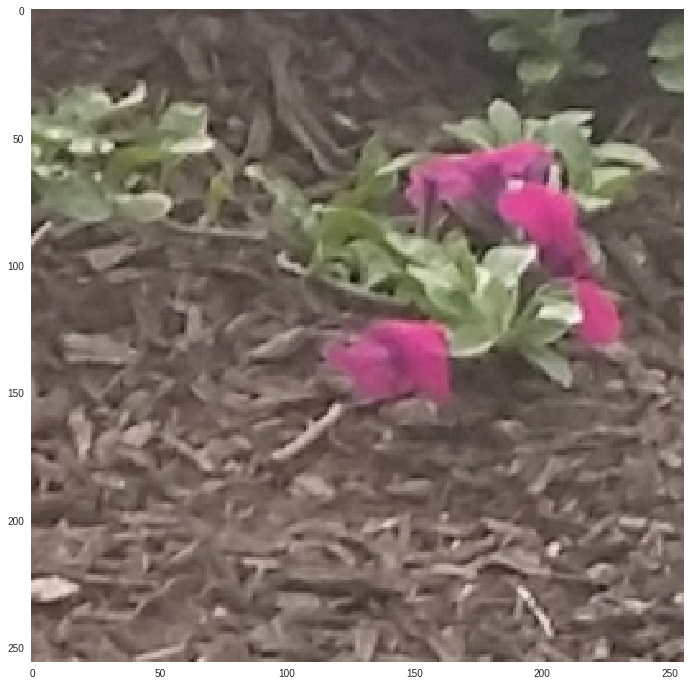

In [37]:
plt.imshow(random.choice(errors[random.choice(list(errors.keys()))]))

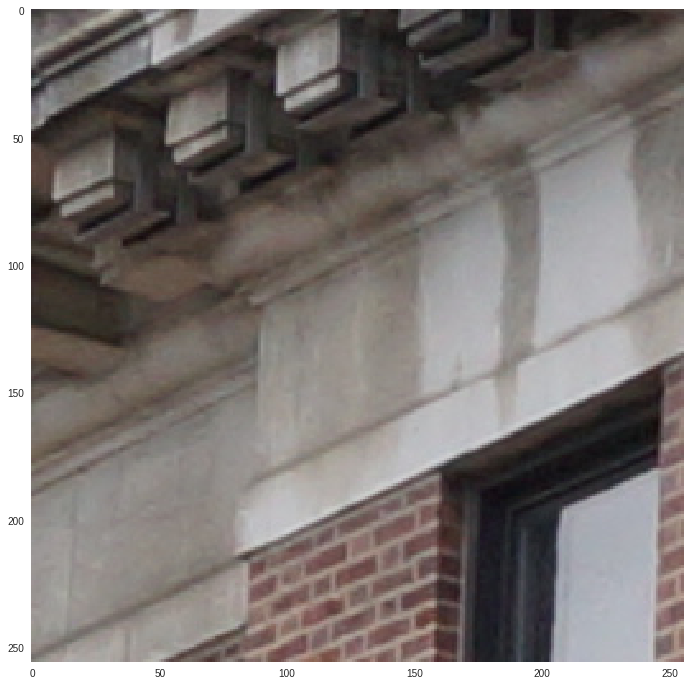

In [31]:
plt.imshow(random.choice(wins[random.choice(list(wins.keys()))]))